In [1]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import colors as clr
import numpy as np
import sys
import re
import fileinput
from scipy.optimize import curve_fit
import operator
#import scipy as scp


# function to change OUTPUT file into space-separated float fields and parameterise the data using this new format
# line in 'with open' bit is type 'str'

# create a function to get spectral grid data
bound_inds = []
oldstr = ['0-','1-','2-','3-','4-','5-','6-','7-','8-','9-']
newstr = ['0 -','1 -','2 -','3 -','4 -','5 -','6 -','7 -','8 -','9 -']

def data_read_gaia(f):
    missed_line_inds = []
    temp_data = []
    temp_rad_zone_data = []
    check = 0
    #number of lines to cut = number of line containing 'convective shell' label - (2 + any additional string lines)
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(4,1,-1):
            line = line.replace((x*' '),' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        if match_ast or match_inf or (line.strip()==''):
            missed_line_inds.append(check)
            #continue
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)

    print 'Total dataset: ',out_all_data.shape
    return out_all_data

# select the parameter (Teff or log(g) for each array(file)) with which to analyse the filter profiles,
# by setting the other to be constant, using the column number (integer)
def grid_vals_dict(input_arr,col_numb):
    col_vals = []
    col_var_arrs = {}
    # create list of values of the column NOT being examined
    for i in range(len(input_arr[:,(col_numb - 1)])):
        if (input_arr[i,(col_numb - 1)] not in col_vals):
            col_vals.append(input_arr[i,(col_numb - 1)])
    print 'Table column',col_numb,'values list: ',col_vals
    # create arrays for fixed values of col_numb parameter
    # by
    for j in col_vals:
        temp_k_list = []
        for k in range(len(input_arr[:,(col_numb - 1)])):
            if (input_arr[k,(col_numb - 1)] == j):
                temp_k_list.append(input_arr[k,:])
        temp_k_array = np.array(temp_k_list)
        #print 'For column',col_numb,'value of',j,', the array has the following shape: ',temp_k_array.shape
        col_var_arrs[str(j)] = temp_k_array
    print 'Final dictionary length: ',len(col_var_arrs)
    return col_var_arrs, col_vals

# To do for plots:
# X, Y axes labels
# 

# Function to plot multiple Teff or log(g) lines (for 1 filter output ONLY!)
# Input: dictionary of relevant arrays, pyplot axes name (text),fixed input variable values (list of strings)
def dict_2D_plot(input_dict,ax,col_x,col_y,var_names,col_map):
    label_int = 6
    if (col_x == 1):
        label_int = 1
    elif (col_x == 2):
        label_int = 0
        
    plt.gca().set_color_cycle([col_map(j) for j in np.linspace(1, 0, len(input_dict))])
    # grid_vals_dict gives the fixed value as the key for the array
    for i in reversed(sorted(input_dict.iterkeys())):
        ax.plot((input_dict[i])[:,(col_x-1)],(input_dict[i])[:,(col_y-1)],label=(var_names[label_int]+'='+i))
    ax.set_xlabel(var_names[(col_x-1)])
    ax.set_ylabel(var_names[(col_y-1)])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.1))
    #ax.set_title('Stuff',y=1.05)
    plt.show()
    
def diff_grid_dict(dict_Av0,dict_Avne0):
    diff_dict = {}
    
    # use sets to match keys in dictionaries
    combined_set = set(dict_Av0).intersection(set(dict_Avne0))
    print len (combined_set)
    for key_val in combined_set:
        #print key_val
        # use variables to store each key value
        Av0_arr_kv = dict_Av0[key_val]
        Avne0_arr_kv = dict_Avne0[key_val]
        # take the difference of the two sets of filter magnitudes for different calibrations of BCs
        # gives absolute extinction A(X) as numerical output
        diff_arr_kv = Av0_arr_kv - Avne0_arr_kv
        for n in range(len(diff_arr_kv[0,:])):
            if (n == 0 or n == 1):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                diff_arr_kv[:,n] = Av0_arr_kv[:,n]
        diff_dict[key_val] = diff_arr_kv
        if (diff_arr_kv.shape != Avne0_arr_kv.shape):
            print 'shape error'
    print 'Raw A(X) dictionary complete'
    return diff_dict

# general fits write-out function

def general_fit_number_gen_write(f,func_type,func_coeffs,covar_matrix,filter_str,logg_val,avg_dict):
    frac_list = []
    output_names = ['    Fit coefficients (in order of functions'' arguments):','    Covariance matrix:']
    f.write('Fitting results for ' + str(filter_str) + ' filter, with log(g) = ' + str(logg_val) + '\n')
    f.write('Function type:  ' + func_type + '\n')
    f.write(output_names[0] + '\n')
    f.write(str(func_coeffs) + '\n')
    f.write(output_names[1] + '\n')
    f.write(str(covar_matrix) + '\n')
    f.write('Fractional errors in fit coefficients = {E[(X(i)-E[X(i)])*(X(j)-E[X(j)])]}/{|E[X(i)]*E[X(j)]|}' + '\n')
    f.write('i.e., covariance(i,j)/{coef(i)*coef(j)}' + 2*'\n')
    f.write('Fractional error output:  ' + '\n')
    # write out errors as detailed above
    
    sum_y = 0
    yterm_count = 0
    for i in range(len(func_coeffs)):
        f.write('row ' + str(i+1) + 2*'\t')
        for j in range(len(func_coeffs)):
            # use if statement to avoid repeating terms in symmetrical covariance matrix
            # should result in increasing number of entries for increasing row number
            if (j <= i):
                y = abs(covar_matrix[i][j]/(func_coeffs[i]*func_coeffs[j]))
                f.write(str(y) + '\t')
                yterm_count += 1
                sum_y += y
        f.write('\n')
    f.write('\n')
    avg_y = sum_y/yterm_count
    avg_dict[func_type] = avg_y
    f.write('Average fractional error = ' + str(avg_y) + 2*'\n')
    print 'Average fractional error for ' + func_type + ' = ' + str(avg_y)
    
# Modelling functions below!!!

# single power-law term
def single_poly(xdata,a,b,c):
    y = a*(xdata**b) + c
    return y

# exponential function
def exp_func(xdata,a,b,c):
    y = (a*(np.exp(b*xdata))) + c
    return y


# logarithmic function
def log_func(xdata,a,b,c):
    y = (a*(np.log10(b*xdata))) + c
    return y

# exponential function added to Teff^d
def single_poly_plus_exp_func(xdata,a,b,c,d):
    y = (xdata**d) + (a*(np.exp(b*xdata))) + c
    return y


# function to produce window of acceptability
    
print 'modules loaded & functions compiled'

modules loaded & functions compiled


In [24]:
# N.B.: usiing cgs unit
with open ("gaia_spectra/OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_data = data_read_gaia(Av0zs)

T_Av0zs = Av0zs_data[:,0]
log_g_Av0zs = Av0zs_data[:,1]
gaia_filter_G_Av0zs = Av0zs_data[:,2]
gaia_filter_G_bp_Av0zs = Av0zs_data[:,3]
gaia_filter_G_rp_Av0zs = Av0zs_data[:,4]

with open ("gaia_spectra/OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_data = data_read_gaia(Av1zs)
    
T_Av1zs = Av1zs_data[:,0]
log_g_Av1zs = Av1zs_data[:,1]
gaia_filter_G_Av1zs = Av1zs_data[:,2]
gaia_filter_G_bp_Av1zs = Av1zs_data[:,3]
gaia_filter_G_rp_Av1zs = Av1zs_data[:,4]

with open ("gaia_spectra/OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_data = data_read_gaia(Av0z2)
    
T_Av0z2 = Av0z2_data[:,0]
log_g_Av0z2 = Av0z2_data[:,1]
gaia_filter_G_Av0z2 = Av0z2_data[:,2]
gaia_filter_G_bp_Av0z2 = Av0z2_data[:,3]
gaia_filter_G_rp_Av0z2 = Av0z2_data[:,4]
    
with open ("gaia_spectra/OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av1z2_data = data_read_gaia(Av1z2)
    
T_Av1z2 = Av1z2_data[:,0]
log_g_Av1z2 = Av1z2_data[:,1]
gaia_filter_G_Av1z2 = Av1z2_data[:,2]
gaia_filter_G_bp_Av1z2 = Av1z2_data[:,3]
gaia_filter_G_rp_Av1z2 = Av1z2_data[:,4]

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
#print Av0z2_logg_fix['5.0']
"""
print '****Separating data into arrays by Teff values****'
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_data,1)
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_data,1)"""
print '****Finished arrays****'
#print type(Av0zs_Teff_vals[0])
A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)

print type(A_X_z2_gfix)
print type(A_X_z2_gfix['0.0'])
#A_X_zs_Tfix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
#A_X_z2_Tfix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)


var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$','log($T_{eff}$ / K)']

# sort data into columns

Teff_5_zs = (A_X_zs_gfix['5.0'])[:,0]
# convert Teff to logs
log_Teff_5_zs = np.log10(Teff_5_zs)
A_G_5_zs = (A_X_zs_gfix['5.0'])[:,2]
A_Gbp_5_zs = (A_X_zs_gfix['5.0'])[:,3]
A_Grp_5_zs = (A_X_zs_gfix['5.0'])[:,4]

Teff_5_z2 = (A_X_z2_gfix['5.0'])[:,0]
# convert Teff to logs
log_Teff_5_z2 = np.log10(Teff_5_z2)
A_G_5_z2 = (A_X_z2_gfix['5.0'])[:,2]
A_Gbp_5_z2 = (A_X_z2_gfix['5.0'])[:,3]
A_Grp_5_z2 = (A_X_z2_gfix['5.0'])[:,4]

# strings describing functions being fitted to the data
fit_types = []

fit_types.append('Exponential function of Teff, fitted')
fit_types.append('Power law of Teff, fitted')
fit_types.append('Power law + exponential function of Teff, fitted')



#print len(fit_types)
print 'Variable data arrays organized'


    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)
****Creating arrays****
****Separating data into arrays by log(g) values****
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
****Finished arrays****
11
Raw A(X) dictionary complete
11
Raw A(X) dictionary complete
<type 'dict'>
<type 'numpy.ndarray'>
Variable data arrays organized


5.0
Exponential fit coefficients: 
[ -6.53428506e-01  -2.26385788e-04   1.01965672e+00]
Covariance matrix: 
[[  2.79338034e-04   7.70976187e-08   6.76584212e-06]
 [  7.70976187e-08   2.57620527e-11   3.87030584e-09]
 [  6.76584212e-06   3.87030584e-09   1.79492898e-06]]
Teff^(n) fit coefficients: 
[ -6.78196264e+03  -1.21016771e+00   1.04529154e+00]
Covariance matrix: 
[[  1.26424393e+06   2.26449852e+01   1.53556411e+00]
 [  2.26449852e+01   4.06236140e-04   2.80097180e-05]
 [  1.53556411e+00   2.80097180e-05   2.54851094e-06]]
Teff^(n) + exponential fit coefficients: 
[ -7.28410125e-01  -3.20581546e-04  -2.83317883e-01   2.54424812e-02]
Covariance matrix: 
[[  1.41089768e-04   5.49776452e-08   5.13845228e-05  -3.71740651e-06]
 [  5.49776452e-08   2.87775632e-11   4.03664603e-08  -2.95850753e-09]
 [  5.13845228e-05   4.03664603e-08   8.29031024e-05  -6.16782700e-06]
 [ -3.71740651e-06  -2.95850753e-09  -6.16782700e-06   4.59761525e-07]]


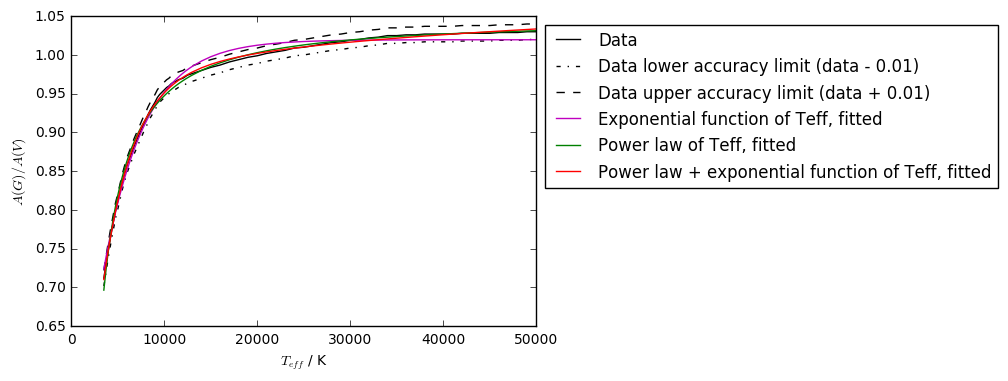


    Writing log(g)=5.0, Z = Zsolar model
Average fractional error for Exponential function of Teff, fitted = 0.000284456515716
Average fractional error for Power law of Teff, fitted = 0.005127355884
Average fractional error for Power law + exponential function of Teff, fitted = 0.000463682342871
Writing complete for G filter
Exponential fit coefficients: 
[ -3.70533710e-01  -1.58115947e-04   1.20796849e+00]
Covariance matrix: 
[[  2.07691944e-04   8.88355531e-08   8.04348948e-06]
 [  8.88355531e-08   5.13881156e-11   9.76299771e-09]
 [  8.04348948e-06   9.76299771e-09   4.84155446e-06]]
Teff^(n) fit coefficients: 
[-279.83920256   -0.84814553    1.24655545]
Covariance matrix: 
[[  3.03569192e+03   1.35015522e+00   1.47982235e-01]
 [  1.35015522e+00   6.01607631e-04   6.68238175e-05]
 [  1.47982235e-01   6.68238175e-05   8.41328170e-06]]
Teff^(n) + exponential fit coefficients: 
[ -7.32738850e-01  -5.08885306e-04  -2.74807149e-01   3.75818932e-02]
Covariance matrix: 
[[  3.24578950e-03

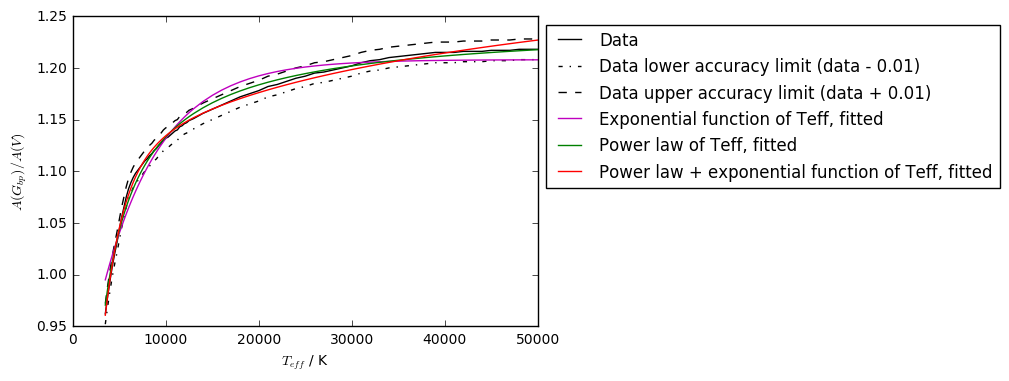


    Writing log(g)=5.0, Z = Zsolar model
Average fractional error for Exponential function of Teff, fitted = 0.000859484759811
Average fractional error for Power law of Teff, fitted = 0.00763047006896
Average fractional error for Power law + exponential function of Teff, fitted = 0.0015496417732
Writing complete for Gbp filter
Exponential fit coefficients: 
[ -1.29780861e-01  -2.37359635e-04   6.73284564e-01]
Covariance matrix: 
[[  1.49136285e-05   2.10909954e-08   3.38301239e-07]
 [  2.10909954e-08   3.56808576e-11   9.52798945e-10]
 [  3.38301239e-07   9.52798945e-10   7.96362536e-08]]
Teff^(n) fit coefficients: 
[ -2.21789150e+03  -1.27666434e+00   6.77635145e-01]
Covariance matrix: 
[[  9.39704207e+04   5.13638809e+00   5.91670992e-02]
 [  5.13638809e+00   2.81167521e-04   3.29448475e-06]
 [  5.91670992e-02   3.29448475e-06   5.26189885e-08]]
Teff^(n) + exponential fit coefficients: 
[ -1.55125056e-01  -3.53534409e-04  -3.93549675e-01   6.22946574e-03]
Covariance matrix: 
[[  1.1

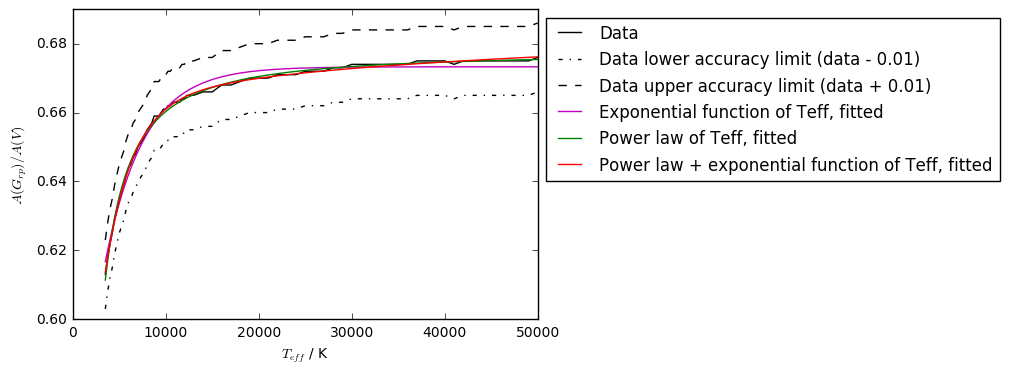


    Writing log(g)=5.0, Z = Zsolar model
Average fractional error for Exponential function of Teff, fitted = 0.000368906681744
Average fractional error for Power law of Teff, fitted = 0.00352220173741
Average fractional error for Power law + exponential function of Teff, fitted = 0.000354922219858
Writing complete for Grp filter

 Writing complete for log(g) = 5.0, Z = sol_100 configuration, END OF FUNCTION WRITING!!!


In [34]:
# try a function to reduce oppportunities for error for stuff below
# during curve fitting - tests, plots & writes out figure, writes out results of covariance matrix analysis

# filter string names
filter_str = ['G','Gbp','Grp']
# curve fitting coefficients' bounds
exp_bounds = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds = ([-1.0e+08, -5., -3.], [1., 1., 4.])
spp_bounds = ([-100., -1., -4., -5.], [1., 1., 2., 1.])

def filter_curve_plot_write(key,metal,exp_bounds,pow_bounds,spp_bounds):
    if (metal == 'solar'):
        A_X_chosen = A_X_zs_gfix[key]
    elif (metal == 'sol_100'):
        A_X_chosen = A_X_z2_gfix[key]
    else:
        print 'Error! Incorrect metallicity input'
        A_X_chosen = []
    # Iteration for changes BETWEEN filters !!!
    # i.e., should produce 3 versions of each output each time the function is called
    for i in range(2,5):
        # empty directory string - avoid potential concatonation
        plot_dir_str_i = None
        data_dir_str_i = None
        # curve-fitting commands
        exp_fit_A_G5zs, covarr_A_G5zs_ef = curve_fit(exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=exp_bounds)
        pow_fit_A_G5zs, covarr_A_G5zs_pow = curve_fit(single_poly,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=pow_bounds)
        spp_exp_fit_A_G5zs, covarr_A_G5zs_spp = curve_fit(single_poly_plus_exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=spp_bounds)
        
        # print fitting results
        print 'Exponential fit coefficients: '
        print exp_fit_A_G5zs
        print 'Covariance matrix: '
        print covarr_A_G5zs_ef

        print 'Teff^(n) fit coefficients: '
        print pow_fit_A_G5zs
        print 'Covariance matrix: '
        print covarr_A_G5zs_pow

        print 'Teff^(n) + exponential fit coefficients: '
        print spp_exp_fit_A_G5zs
        print 'Covariance matrix: '
        print covarr_A_G5zs_spp
        
        # Construct directories, files to save plots,data - i.e. construct strings
        # String format should be: 'gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf' (example case)
        plot_dir_str_i = 'gaia_spectra/gaia_graphs/A' + filter_str[i-2] + '_logg=' + key + '_' + metal + '_Teff_fit_plot.pdf'
        data_dir_str_i = 'gaia_spectra/Teff_A' + filter_str[i-2] + '_gen_fit_logg=' + key + '_' + metal + '_numbers.txt'
        # plot commands
        fig, ax = plt.subplots()
        ax.set_xlabel(var_names[0])
        ax.set_ylabel(var_names[i])
        
        ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',label='Data')
        ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
        ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
        ax.plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_G5zs),'m',label=fit_types[0])
        ax.plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_G5zs),'g',label=fit_types[1])
        ax.plot(A_X_chosen[:,0],single_poly_plus_exp_func(A_X_chosen[:,0],*spp_exp_fit_A_G5zs),'r',label=fit_types[2])
        
        #ax.set_xlim(3000,10000)
        plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        plt.show()
        fig.savefig(plot_dir_str_i, bbox_inches='tight')
                
        # data file write commands
        
        avg_dict = {}
        with open (data_dir_str_i,'w') as f:
            print '\n    Writing log(g)=5.0, Z = Zsolar model'
            general_fit_number_gen_write(f,fit_types[0],exp_fit_A_G5zs, covarr_A_G5zs_ef,filter_str[i-2],float(key),avg_dict)
            general_fit_number_gen_write(f,fit_types[1],pow_fit_A_G5zs, covarr_A_G5zs_pow,filter_str[i-2],float(key),avg_dict)
            general_fit_number_gen_write(f,fit_types[2],spp_exp_fit_A_G5zs, covarr_A_G5zs_spp,filter_str[i-2],float(key),avg_dict)

            # write results of comparison of averages
            sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
            f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
            for j in sorted_avg:
                f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
            f.close()
        print 'Writing complete for ' + filter_str[i-2] + ' filter'
    print '\n Writing complete for log(g) = ' + key  + ', Z = ' + metal + ' configuration, END OF FUNCTION WRITING!!!'
    
# END OF FUNCTION DEFINITION

# call function to general results
#print float('5.0')
filter_curve_plot_write('5.0','sol_100',exp_bounds,pow_bounds,spp_bounds)


Exponential fit coefficients: 
[ -2.02565531e-01  -3.17447181e-04   6.72503207e-01]
Covariance matrix: 
[[  1.86453970e-04   1.86949961e-07   2.59417521e-06]
 [  1.86949961e-07   2.10552390e-10   4.18389053e-09]
 [  2.59417521e-06   4.18389053e-09   2.81609726e-07]]
Teff^(n) fit coefficients: 
[ -7.76300584e+04  -1.69497690e+00   6.75272787e-01]
Covariance matrix: 
[[  6.56252529e+08   1.01896093e+03   7.34381789e+00]
 [  1.01896093e+03   1.58393130e-03   1.16220484e-05]
 [  7.34381789e+00   1.16220484e-05   1.43825766e-07]]
Teff^(n) + exponential fit coefficients: 
[-0.50815154 -0.00062821 -0.41679095  0.00831974]
Covariance matrix: 
[[  2.42639028e-03   1.27503064e-06   1.02345664e-04  -9.06893366e-06]
 [  1.27503064e-06   7.02414213e-10   6.74942148e-08  -6.00314024e-09]
 [  1.02345664e-04   6.74942148e-08   1.43411183e-05  -1.30829393e-06]
 [ -9.06893366e-06  -6.00314024e-09  -1.30829393e-06   1.19743514e-07]]


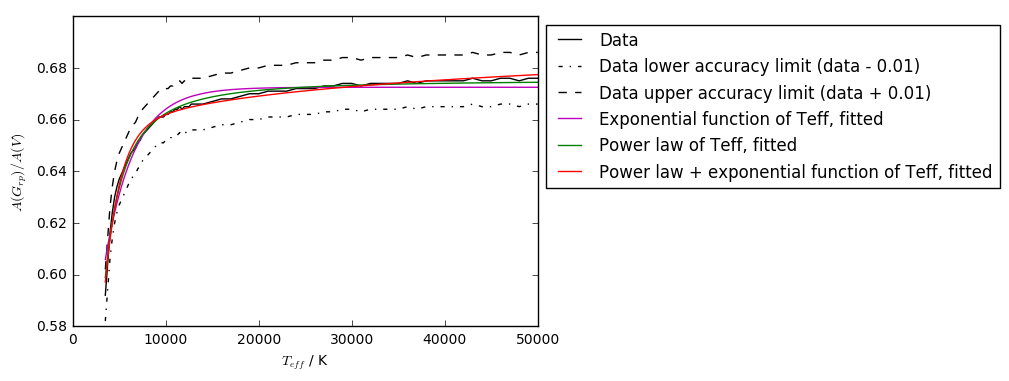

In [18]:
"""
exp_fit_A_G5zs, covarr_A_G5zs_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))
pow_fit_A_G5zs, covarr_A_G5zs_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))
spp_exp_fit_A_G5zs, covarr_A_G5zs_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))
#log_fit_A_G5zs, covarr_A_G5zs_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))

fig, ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[4])

ax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],exp_func((A_X_zs_gfix['5.0'])[:,0],*exp_fit_A_G5zs),'m',label=fit_types[0])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly((A_X_zs_gfix['5.0'])[:,0],*pow_fit_A_G5zs),'g',label=fit_types[1])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly_plus_exp_func((A_X_zs_gfix['5.0'])[:,0],*spp_exp_fit_A_G5zs),'r',label=fit_types[2])

#ax.set_xlim(3000,10000)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf', bbox_inches='tight')
"""

In [19]:
# dictionary of average errors
#'G','G_bp','G_rp'
avg_dict = {}
with open ("gaia_spectra/Teff_AGrp_gen_fit_logg=5.0_zs_numbers.txt",'w') as f:
    print '\n    Writing log(g)=5.0, Z = Zsolar model'
    general_fit_number_gen_write(f,fit_types[0],exp_fit_A_G5zs, covarr_A_G5zs_ef,'G_rp',5.0,avg_dict)
    general_fit_number_gen_write(f,fit_types[1],pow_fit_A_G5zs, covarr_A_G5zs_pow,'G_rp',5.0,avg_dict)
    general_fit_number_gen_write(f,fit_types[2],spp_exp_fit_A_G5zs, covarr_A_G5zs_spp,'G_rp',5.0,avg_dict)

    # write results of comparison of averages
    sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
    f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
    for i in sorted_avg:
        f.write("{: <40}".format(str(i[0])) + 2*'\t' + str(i[1]) + '\n')
    f.close()
    print 'writing complete'


    Writing log(g)=5.0, Z = Zsolar model
Average fractional error for Exponential function of Teff, fitted = 0.00159665936406
Average fractional error for Power law of Teff, fitted = 0.0195569449105
Average fractional error for Power law + exponential function of Teff, fitted = 0.00213951558138
writing complete


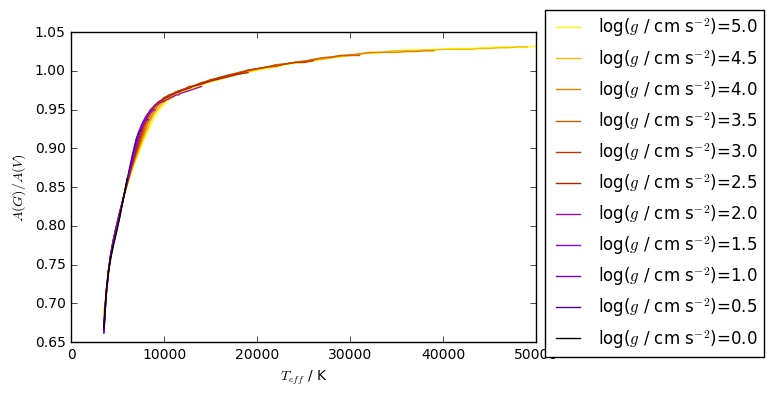

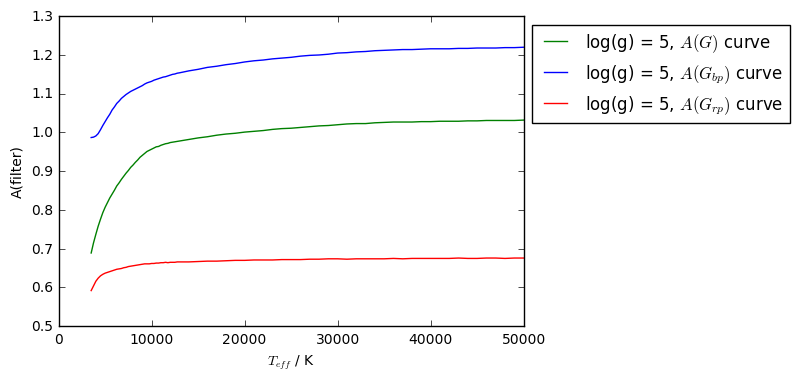

In [7]:
fig, ax = plt.subplots()
col_map = plt.cm.gnuplot
#plt.gca().set_color_cycle([col_map(i) for i in np.linspace(0, 1, len(Teff_vals))])
#gnuplot gist_ncar
#ax.set_xlim(0,15000)
#ax.set_ylim(-2,0)
dict_2D_plot(A_X_zs_gfix,ax,1,3,var_names,col_map)
#fig.savefig('gaia_spectra/gaia_graphs/AG_vs_Teff_at_diff_logg.pdf', bbox_inches='tight')

# plot all 3 filters against Teff together
fig,ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel('A(filter)')
ax.plot(Teff_5_zs,A_G_5_zs,'g', label = 'log(g) = 5, $A(G)$ curve')
ax.plot(Teff_5_zs,A_Gbp_5_zs,'b', label = 'log(g) = 5, $A(G_{bp})$ curve')
ax.plot(Teff_5_zs,A_Grp_5_zs,'r', label = 'log(g) = 5, $A(G_{rp})$ curve')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
#fig.savefig('gaia_spectra/gaia_graphs/Aall_vs_Teff.pdf', bbox_inches='tight')


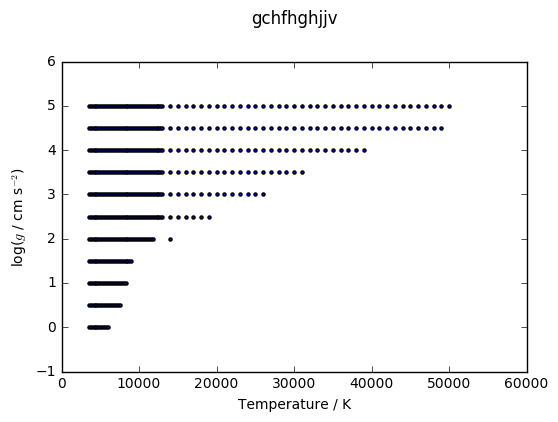

In [44]:
fig, ax = plt.subplots()
#ax.axhline(y=5.0, color='m', linestyle='--')
# Create a continuous norm to map from data points to colors | np.log10((Dthm+1).min()),np.log10((Dthm+1).max())
ax.scatter(T_Av0zs,log_g_Av0zs,marker='.')
ax.set_xlabel('Temperature / K')
ax.set_ylabel('log($g$ / cm s$^{-2}$)')
#ax.set_xlim(['5.02, 0.1])
#ax.set_ylim([0, 0.1])
#plt.show()
#ax.set_title('gchfhghjjv', y=1.1)
fig.savefig('gaia_spectra/gaia_graphs/hgchgftf.pdf', bbox_inches='tight')